# Train EfficientNet on Fruits 360

We want to use the latest version of `torchvision`, Kaggle's current version of torchvision doesn't include EfficientNet, it was added in a later release

In [ ]:
!pip install -U torchvision
!pip install timm

## Imports

Import all necesssary libraries for this project

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models

In [4]:
torchvision.__version__, torch.__version__ # ('0.11.2+cu102', '1.10.1+cu102') or higher

('0.11.3+cu102', '1.10.2+cu102')

In [5]:
import matplotlib.pyplot as plt
import os
import sys
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
from tqdm import tqdm
import time
import copy

## Dataset

In [7]:
dataset_path = "/kaggle/input/fruits/fruits-360_dataset/fruits-360/"

In [8]:
def get_data_loaders(data_dir, batch_size=64, train = False):
    if train:
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter(), 
                                                        transforms.GaussianBlur(3)]), p=0.1),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            transforms.RandomErasing(p=0.14, value='random')
        ])
        train_set = datasets.ImageFolder(os.path.join(data_dir, "Training/"), transform=transform)
        print(f"Found {len(train_set)} images for training with {len(train_set.classes)} classes")
        train_data_len = int(len(train_set)*0.78)
        valid_data_len = int((len(train_set) - train_data_len))
        train_data, val_data = random_split(train_set, [train_data_len, valid_data_len])
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
        return train_loader, val_loader, len(train_data), len(val_data)
    
    else:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
        test_data = datasets.ImageFolder(os.path.join(data_dir, "Test/"), transform=transform)
        print(f"Found {len(test_data)} images for testing with {len(test_data.classes)} classes")
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
        return test_loader, len(test_data)

In [9]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [10]:
classes = get_classes(os.path.join(dataset_path, "Training/"))
len(classes)

131

In [11]:
(train_loader, val_loader, train_data_len, valid_data_len) = get_data_loaders(dataset_path, 256, train=True)
(test_loader, test_data_len) = get_data_loaders(dataset_path, 64, train=False)

Found 67692 images for training with 131 classes
Found 22688 images for testing with 131 classes


In [12]:
dataloaders = {
    "train":train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train":train_data_len,
    "val": valid_data_len
}

In [13]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

207
59
355


In [14]:
print(train_data_len, test_data_len, valid_data_len)

52799 22688 14893


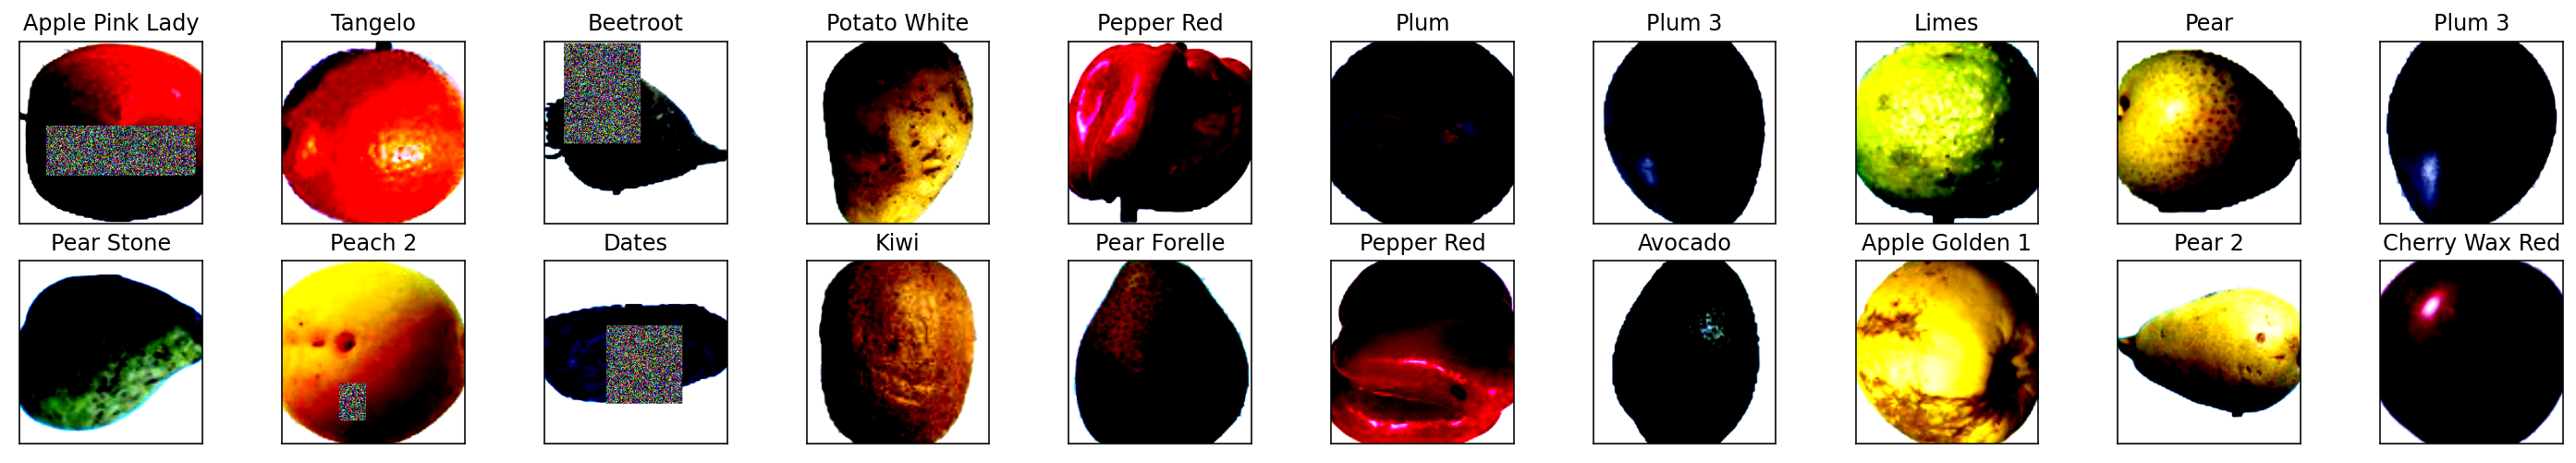

In [15]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

## Model

Load `efficientnet_b0` from torchvision Models

In [16]:
import timm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [17]:
torch.backends.cudnn.benchmark = True # This will speed up training
model = models.efficientnet_b0(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
n_inputs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(n_inputs,2048),
    nn.SiLU(),
    nn.Dropout(0.2),
    nn.Linear(2048, len(classes))
)

model = model.to(device)
print(model.classifier)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

Sequential(
  (0): Linear(in_features=1280, out_features=2048, bias=True)
  (1): SiLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=2048, out_features=131, bias=True)
)


In [18]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.11)
criterion = criterion.to(device)
optimizer = optim.AdamW(model.classifier.parameters(), lr=0.001)

In [19]:
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.8)

In [20]:
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

## Training

In [21]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                training_history['accuracy'].append(epoch_acc)
                training_history['loss'].append(epoch_loss)
            elif phase == 'val':
                validation_history['accuracy'].append(epoch_acc)
                validation_history['loss'].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [22]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=2)

Epoch 0/1
----------


100%|██████████| 207/207 [03:41<00:00,  1.07s/it]


train Loss: 1.4449 Acc: 0.9215


100%|██████████| 59/59 [01:04<00:00,  1.09s/it]


val Loss: 1.0577 Acc: 0.9937

Epoch 1/1
----------


100%|██████████| 207/207 [02:28<00:00,  1.39it/s]


train Loss: 1.0586 Acc: 0.9918


100%|██████████| 59/59 [00:41<00:00,  1.43it/s]

val Loss: 1.0003 Acc: 0.9978

Training complete in 7m 56s
Best val Acc: 0.997784


## Evaluation

In [23]:
def test(model):
  test_loss = 0.0
  class_correct = list(0. for i in range(len(classes)))
  class_total = list(0. for i in range(len(classes)))

  model.eval()

  for data, target in tqdm(test_loader):
      if torch.cuda.is_available(): 
          data, target = data.cuda(), target.cuda()
      with torch.no_grad():
        output = model(data)
        loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)
      _, pred = torch.max(output, 1)    
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
      if len(target) == 64:
        for i in range(64):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

  test_loss = test_loss/len(test_loader.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  for i in range(len(classes)):
      if class_total[i] > 0:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  print('\nTest Accuracy (Overall): {:.4f} ({}/{})'.format(
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))

In [24]:
test(model_ft)

100%|██████████| 355/355 [01:29<00:00,  3.96it/s]

Test Loss: 1.043989

Test Accuracy of Apple Braeburn: 98% (161/163)
Test Accuracy of Apple Crimson Snow: 87% (130/148)
Test Accuracy of Apple Golden 1: 100% (160/160)
Test Accuracy of Apple Golden 2: 100% (164/164)
Test Accuracy of Apple Golden 3: 97% (157/161)
Test Accuracy of Apple Granny Smith: 98% (162/164)
Test Accuracy of Apple Pink Lady: 88% (134/151)
Test Accuracy of Apple Red 1: 95% (156/164)
Test Accuracy of Apple Red 2: 94% (155/164)
Test Accuracy of Apple Red 3: 99% (143/144)
Test Accuracy of Apple Red Delicious: 100% (166/166)
Test Accuracy of Apple Red Yellow 1: 98% (161/164)
Test Accuracy of Apple Red Yellow 2: 100% (219/219)
Test Accuracy of Apricot: 100% (164/164)
Test Accuracy of Avocado: 100% (142/142)
Test Accuracy of Avocado ripe: 100% (166/166)
Test Accuracy of Banana: 100% (165/165)
Test Accuracy of Banana Lady Finger: 100% (152/152)
Test Accuracy of Banana Red: 100% (165/165)
Test Accuracy of Beetroot: 89% (133/149)
Test Accuracy of Blueberry: 100% (154/154)
Tes

## Save as torchscript model

In [25]:
example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(model_ft.cpu(), example)
traced_script_module.save("fruits-360-efficientnet_b0.zip")